# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата  
  
- **Целевой признак Exited** — факт ухода клиента

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.shape

(10000, 14)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Наблюдаем, что пропуски имеются только в колонке **Tenure**.      
Отсутствие данных в таком случае, вероятно, говорит о новом клиенте.  
Следовательно, мы заполним эти пропуски нулями, предварительно переименовав все колонки для удобства использования, а затем избавимся от явных дубликатов, если таковые имеются.

In [5]:
data = data.rename(columns={'RowNumber':'row_number', 'CustomerId':'customer_id',
                            'CreditScore':'credit_score', 'NumOfProducts':'num_of_products',
                            'HasCrCard':'has_cr_card', 'IsActiveMember':'is_active_member',
                            'EstimatedSalary':'estimated_salary'})

In [6]:
data.columns = data.columns.str.lower()

In [7]:
data['tenure'] = data['tenure'].fillna(data['tenure'].median())

In [8]:
data = data.drop_duplicates()

Взглянем на общую картину, поищем аномалии и выбросы

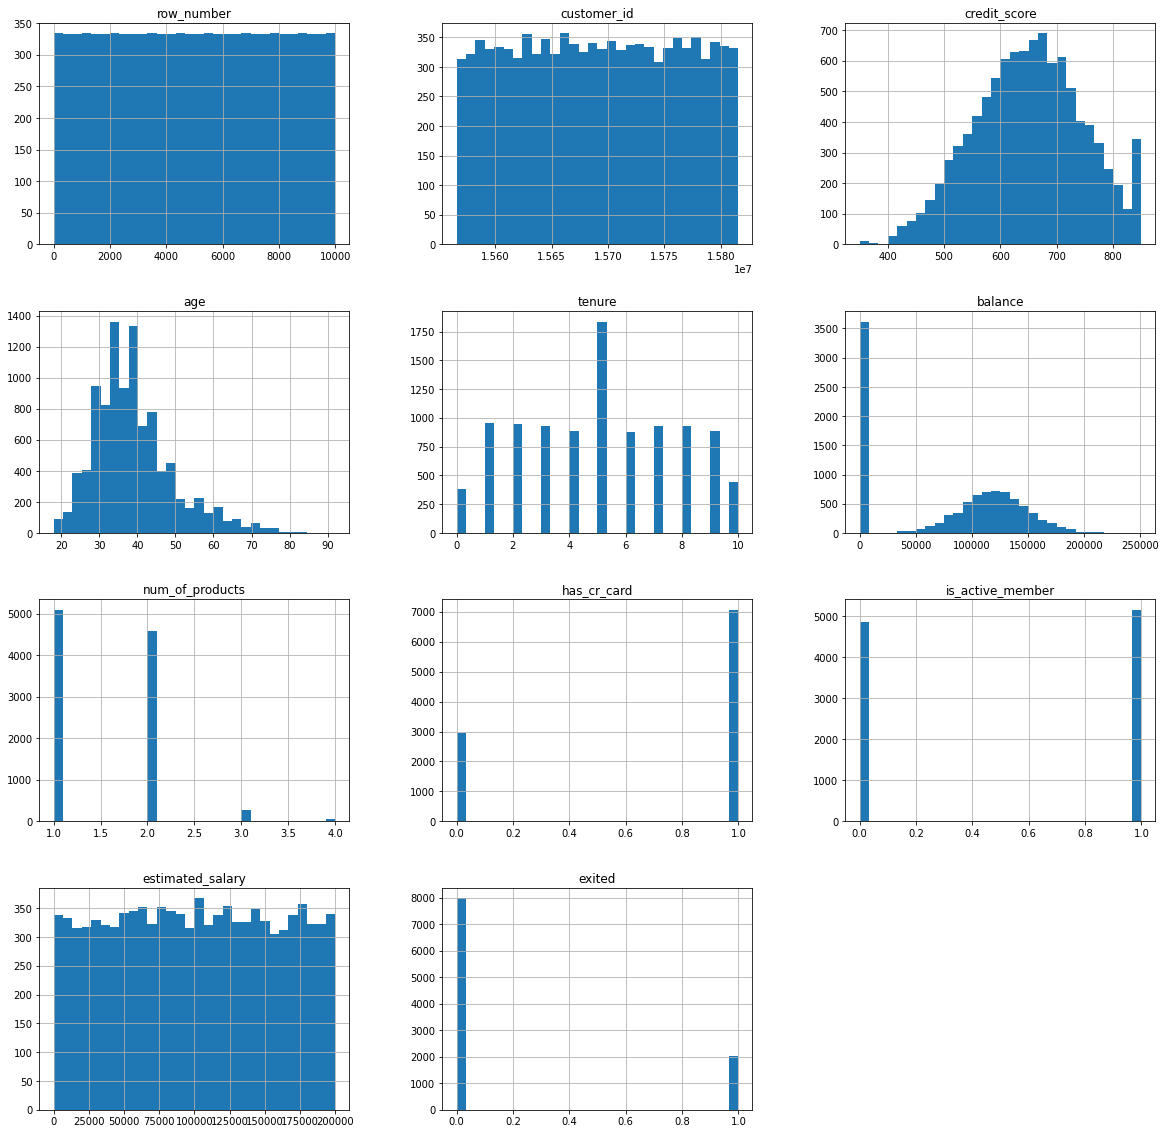

In [9]:
data.hist(figsize=(20, 20), bins=30)
plt.show()

Ничего необычного не обнаружено, высокие столбцы не являются аномальными.

## Исследование задачи

Итак, взглянем на данные ещё раз

In [10]:
data.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Первые три колонки абсолютно уникальны для каждого клиента и не пригодятся при построении модели, следует сразу их отделить

In [11]:
data.drop(columns=['row_number', 'customer_id', 'surname'], inplace=True)

### One-Hot-Encoding

Для дальнейшего применения линейных моделей используем метод One-Hot-Encoding

In [12]:
data_dummies = pd.get_dummies(data, drop_first=True)
data_dummies.columns = data_dummies.columns.str.lower()
data_dummies.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### Формирование выборок

Выделим фичи и целевой признак, проведём разбивку на выборки

In [13]:
target = data_dummies['exited']
features = data_dummies.drop(columns=['exited'])

In [14]:
features_train, features_valid, target_train,target_valid = \
    train_test_split(features, target, test_size=0.4, random_state=42)

features_valid, features_test, target_valid, target_test = \
    train_test_split(features_valid, target_valid, test_size=0.5, random_state=42)

In [15]:
features_train.shape, features_valid.shape, features_test.shape

((6000, 11), (2000, 11), (2000, 11))

## Борьба с дисбалансом

In [16]:
target.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

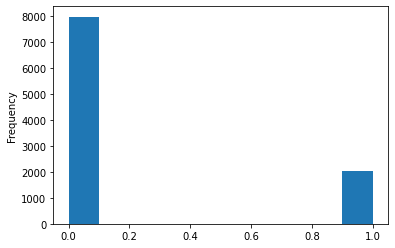

In [17]:
target.plot(kind='hist')
plt.show()

Дисбаланс классов видео невооружённым взглядом.  
Но всё же сначала проверим модели с дисбалансом классов, а затем устраним его. 

### Масштабирование числовых признаков

Проведём масштабирование для улучшения работы моделей

In [18]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [19]:
scaled_features_train = features_train
scaled_features_valid = features_valid
scaled_features_test = features_test

In [20]:
scaled_features_train[numeric] = scaler.transform(scaled_features_train[numeric])
scaled_features_valid[numeric] = scaler.transform(scaled_features_valid[numeric])
scaled_features_test[numeric] = scaler.transform(scaled_features_test[numeric])

In [21]:
scaled_features_train.sample(3)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
8029,0.192066,1.068808,1.097514,-1.214721,1,0,1,-1.709387,0,1,1
608,0.482566,-0.369459,0.012657,-1.214721,2,1,1,-0.395112,0,0,1
2604,-1.167062,-1.328303,0.012657,0.642751,1,1,0,-1.521327,0,0,1


### Логистическая регрессия с дисбалансом классов

Для начала взглянем на результаты двух моделей, не устраняя дисбаланс классов

In [22]:
logreg = LogisticRegression(random_state=42)

In [23]:
logreg.fit(scaled_features_train, target_train)

LogisticRegression(random_state=42)

In [24]:
predicted_valid = logreg.predict(scaled_features_valid)
f1_score(target_valid, predicted_valid)

0.29615384615384616

In [25]:
roc_auc_score(target_valid, logreg.predict_proba(scaled_features_valid)[:, 1])

0.7519818063677712

### Случайный лес с дисбалансом классов

In [26]:
forest = RandomForestClassifier(random_state=42)

In [27]:
forest.fit(scaled_features_train, target_train)

RandomForestClassifier(random_state=42)

In [28]:
predicted_valid = forest.predict(scaled_features_valid)
f1_score(target_valid, predicted_valid)

0.5460526315789473

In [29]:
roc_auc_score(target_valid, forest.predict_proba(scaled_features_valid)[:, 1])

0.8285209551656919

В данном случае модель случайного леса показала себя с лучшей стороны.

### Логистическая регрессия с балансировкой весов классов

In [30]:
balanced_logreg = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
balanced_logreg.fit(scaled_features_train, target_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [31]:
balanced_predicted_valid = balanced_logreg.predict(scaled_features_valid)

In [32]:
f1_score(target_valid, balanced_predicted_valid)

0.46140350877192987

In [33]:
roc_auc_score(target_valid, balanced_logreg.predict_proba(scaled_features_valid)[:, 1])

0.7528476283300845

Как видим, балансировка весов классов положительно повлияла на F1-меры модели логистической регрессии, однако ROC-AUC осталя почти неизменным

### Логистическая регрессия с устранением дисбаланса классов через upsampling

In [34]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
  
    return features_upsampled, target_upsampled

In [35]:
features_upsampled, target_upsampled = upsample(scaled_features_train, target_train, 4)

In [36]:
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)

In [37]:
upsampled_logreg = LogisticRegression(random_state=42)
upsampled_logreg.fit(features_upsampled, target_upsampled)

LogisticRegression(random_state=42)

In [38]:
upsampled_predicted_valid = upsampled_logreg.predict(scaled_features_valid)

In [39]:
f1_score(target_valid, upsampled_predicted_valid)

0.46379310344827585

In [40]:
roc_auc_score(target_valid, upsampled_logreg.predict_proba(scaled_features_valid)[:, 1])

0.7528151397011047

Балансировка классов через upsampling показала схожие результаты

### Случайный лес с балансировкой классов

Теперь посмотрим на модель случайного леса с балансировкой классов

In [41]:
forest = RandomForestClassifier(random_state=42)
forest.fit(features_upsampled, target_upsampled)

RandomForestClassifier(random_state=42)

In [42]:
predicted_valid_forest = forest.predict(scaled_features_valid)

In [43]:
f1_score(target_valid, predicted_valid_forest)

0.562942008486563

In [44]:
roc_auc_score(target_valid, forest.predict_proba(scaled_features_valid)[:, 1])

0.8286362897985705

Наивысший результат.  
Следовательно, эту модель и будем использовать, но сначала подберём гиперпараметры.

### Подбор гиперпараметров

In [45]:
best_f1 = 0

for est in range(5, 101, 10):
    for depth in range(1, 20, 1):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=42)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(scaled_features_valid)
        f1 = f1_score(predicted_valid, target_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_est = est
            best_depth = depth

print(f'Наиболее высокий показатель F1 = {best_f1} у модели случайного леса с параметрами:')
print(f'n_estimators: {best_est}, max_depth: {best_depth}')

Наиболее высокий показатель F1 = 0.5850515463917525 у модели случайного леса с параметрами:
n_estimators: 95, max_depth: 13


In [52]:
roc_auc_score(target_valid, model.predict_proba(scaled_features_valid)[:, 1])

0.8330181936322287

Подбор гиперпараметров позволил повысить показатели как F1-меры, так и метрики ROC-AUC.

## Тестирование модели

In [46]:
model = RandomForestClassifier(n_estimators=best_est, max_depth=best_depth, random_state=42)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(scaled_features_test)
print('F1 лучшей модели на тестовой выборке', f1_score(predicted_test, target_test))

F1 лучшей модели на тестовой выборке 0.6362573099415205


Теперь проверим модель на адекватность

In [47]:
target_zeros = pd.Series(list(0 for i in range(len(target_test))))

In [48]:
print('Accuracy оригинальной модели:', accuracy_score(target_test, predicted_test))
print('Accuracy с нулями:', accuracy_score(target_test, target_zeros))

Accuracy оригинальной модели: 0.8445
Accuracy с нулями: 0.785


**Вывод:** Оригинальная модель оказалась точнее, значит можем считать её адекватной.

### ROC-кривая

Напоследок построим ROC-кривую и выведем значение AUC-ROC

In [49]:
probabilities_test = model.predict_proba(scaled_features_test)
probabilities_one_test = probabilities_test[:, 1]

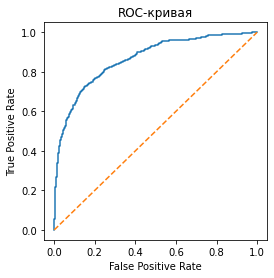

In [50]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure(figsize=(4,4))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [51]:
print('AUC-ROC =', roc_auc_score(target_test, probabilities_one_test))

AUC-ROC = 0.8646452377425566


## Общий вывод

В результате работы нам удалось найти модель прогнозирования оттока клиентов банка с наиболее высоким значением F1-меры. Всему этому поспобоствовали: перевод категориальных признаков в дамми-переменные, устранение дисбаланса классов с помощью upsampling'a.  

Наилучшей моделью оказался RandomForestClassifier с 35 деревьями и глубиной 15. 
- F1 на тестовой выборке =  0.636
- AUC-ROC = 0.864
